# BERT for sequence labelling tasks (PyTorch example)
<sup>This notebook is a part of Natural Language Processing class at the University of Ljubljana, Faculty for computer and information science. Please contact [slavko.zitnik@fri.uni-lj.si](mailto:slavko.zitnik@fri.uni-lj.si) for any comments.</sub>

We will use a [Kaggle dataset](https://www.kaggle.com/abhinavwalia95/entity-annotated-corpus) which is based on Groningen Meaning Bank dataset for named entity recognition.

The model example was inspired and parts of code are taken from [Tobias Sterbak's blog post](https://www.depends-on-the-definition.com/named-entity-recognition-with-bert/).

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm, trange

import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertConfig

from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

import transformers
from transformers import BertForTokenClassification, AdamW

from seqeval.metrics import accuracy_score
from seqeval.metrics import classification_report
from seqeval.metrics import f1_score

print(f"Transformers version: {transformers.__version__}")
print(f"PyTorch version: {torch.__version__}")

Transformers version: 4.4.2
PyTorch version: 1.7.1


In [2]:
if torch.cuda.is_available():
    for i in range(torch.cuda.device_count()):
        print(f"Found GPU device: {torch.cuda.get_device_name(i)}")

Found GPU device: NVIDIA GeForce GTX 980 Ti


In [3]:
df_data = pd.read_csv("ner_dataset.csv", encoding="latin1").fillna(method="ffill")
df_data.shape

(1048575, 4)

In [4]:
print(df_data.head)

<bound method NDFrame.head of               Sentence #           Word  POS Tag
0            Sentence: 1      Thousands  NNS   O
1            Sentence: 1             of   IN   O
2            Sentence: 1  demonstrators  NNS   O
3            Sentence: 1           have  VBP   O
4            Sentence: 1        marched  VBN   O
...                  ...            ...  ...  ..
1048570  Sentence: 47959           they  PRP   O
1048571  Sentence: 47959      responded  VBD   O
1048572  Sentence: 47959             to   TO   O
1048573  Sentence: 47959            the   DT   O
1048574  Sentence: 47959         attack   NN   O

[1048575 rows x 4 columns]>


In [5]:
tag_list = df_data.Tag.unique()
tag_list = np.append(tag_list, "PAD")
print(f"Tags: {', '.join(map(str, tag_list))}")

Tags: O, B-geo, B-gpe, B-per, I-geo, B-org, I-org, B-tim, B-art, I-art, I-per, I-gpe, I-tim, B-nat, B-eve, I-eve, I-nat, PAD


In [6]:
x_train, x_test = train_test_split(df_data, test_size=0.20, shuffle=False, random_state = 42)
x_val, x_test = train_test_split(x_test, test_size=0.50, shuffle=False, random_state = 42)

In [7]:
x_train.shape, x_val.shape, x_test.shape

((838860, 4), (104857, 4), (104858, 4))

In [8]:
agg_func = lambda s: [ [w,t] for w,t in zip(s["Word"].values.tolist(),s["Tag"].values.tolist())]

In [9]:
x_train_grouped = x_train.groupby("Sentence #").apply(agg_func)
x_val_grouped = x_val.groupby("Sentence #").apply(agg_func)
x_test_grouped = x_test.groupby("Sentence #").apply(agg_func)

In [10]:
x_train_sentences = [[s[0] for s in sent] for sent in x_train_grouped.values]
x_val_sentences = [[s[0] for s in sent] for sent in x_val_grouped.values]
x_test_sentences = [[s[0] for s in sent] for sent in x_test_grouped.values]

In [11]:
x_train_tags = [[t[1] for t in tag] for tag in x_train_grouped.values]
x_val_tags = [[t[1] for t in tag] for tag in x_val_grouped.values]
x_test_tags = [[t[1] for t in tag] for tag in x_test_grouped.values]

In [12]:
x_train_sentences[0]

['Thousands',
 'of',
 'demonstrators',
 'have',
 'marched',
 'through',
 'London',
 'to',
 'protest',
 'the',
 'war',
 'in',
 'Iraq',
 'and',
 'demand',
 'the',
 'withdrawal',
 'of',
 'British',
 'troops',
 'from',
 'that',
 'country',
 '.']

In [13]:
x_train_tags[0]

['O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'B-geo',
 'O',
 'O',
 'O',
 'O',
 'O',
 'B-geo',
 'O',
 'O',
 'O',
 'O',
 'O',
 'B-gpe',
 'O',
 'O',
 'O',
 'O',
 'O']

In [14]:
label2code = {label: i for i, label in enumerate(tag_list)}
code2label = {v: k for k, v in label2code.items()}
label2code

{'O': 0,
 'B-geo': 1,
 'B-gpe': 2,
 'B-per': 3,
 'I-geo': 4,
 'B-org': 5,
 'I-org': 6,
 'B-tim': 7,
 'B-art': 8,
 'I-art': 9,
 'I-per': 10,
 'I-gpe': 11,
 'I-tim': 12,
 'B-nat': 13,
 'B-eve': 14,
 'I-eve': 15,
 'I-nat': 16,
 'PAD': 17}

In [15]:
num_labels = len(label2code)
print(f"Number of labels: {num_labels}")

Number of labels: 18


In [16]:
MAX_LENGTH = 128
BATCH_SIZE = 32

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()

if torch.cuda.is_available():
    print(f"GPU device: {torch.cuda.get_device_name(0)}")

GPU device: NVIDIA GeForce GTX 980 Ti


In [17]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased', do_lower_case=False)

In [18]:
def convert_to_input(sentences,tags):
    input_id_list = []
    attention_mask_list = []
    label_id_list = []
    
    for x,y in tqdm(zip(sentences,tags),total=len(tags)):
        tokens = []
        label_ids = []
        
        for word, label in zip(x, y):
            word_tokens = tokenizer.tokenize(word)
            tokens.extend(word_tokens)
            # Use the real label id for the first token of the word, and padding ids for the remaining tokens
            label_ids.extend([label2code[label]] * len(word_tokens))

        input_ids = tokenizer.convert_tokens_to_ids(tokens)

        input_id_list.append(input_ids)
        label_id_list.append(label_ids)

    input_id_list = pad_sequences(input_id_list,
                          maxlen=MAX_LENGTH, dtype="long", value=0.0,
                          truncating="post", padding="post")
    label_id_list = pad_sequences(label_id_list,
                     maxlen=MAX_LENGTH, value=label2code["PAD"], padding="post",
                     dtype="long", truncating="post")
    attention_mask_list = [[float(i != 0.0) for i in ii] for ii in input_id_list]

    return input_id_list, attention_mask_list, label_id_list

In [19]:
input_ids_train, attention_masks_train, label_ids_train = convert_to_input(x_train_sentences, x_train_tags)
input_ids_val, attention_masks_val, label_ids_val = convert_to_input(x_val_sentences, x_val_tags)
input_ids_test, attention_masks_test, label_ids_test = convert_to_input(x_test_sentences, x_test_tags)

100%|██████████| 4835/4835 [00:04<00:00, 1046.71it/s]


In [20]:
np.shape(input_ids_train), np.shape(attention_masks_train), np.shape(label_ids_train)

((38346, 128), (38346, 128), (38346, 128))

In [21]:
np.shape(input_ids_val), np.shape(attention_masks_val), np.shape(label_ids_val)

((4780, 128), (4780, 128), (4780, 128))

In [22]:
np.shape(input_ids_test), np.shape(attention_masks_test), np.shape(label_ids_test)

((4835, 128), (4835, 128), (4835, 128))

In [23]:
train_inputs = torch.tensor(input_ids_train)
train_tags = torch.tensor(label_ids_train)
train_masks = torch.tensor(attention_masks_train)

val_inputs = torch.tensor(input_ids_val)
val_tags = torch.tensor(label_ids_val)
val_masks = torch.tensor(attention_masks_val)

test_inputs = torch.tensor(input_ids_test)
test_tags = torch.tensor(label_ids_test)
test_masks = torch.tensor(attention_masks_test)

In [24]:
train_data = TensorDataset(train_inputs, train_masks, train_tags)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=BATCH_SIZE)

valid_data = TensorDataset(val_inputs, val_masks, val_tags)
valid_sampler = SequentialSampler(valid_data)
valid_dataloader = DataLoader(valid_data, sampler=valid_sampler, batch_size=BATCH_SIZE)

test_data = TensorDataset(test_inputs, test_masks, test_tags)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=BATCH_SIZE)

In [25]:
model = BertForTokenClassification.from_pretrained(
    "bert-base-cased",
    num_labels=len(label2code),
    output_attentions = False,
    output_hidden_states = False
)


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cas

In [26]:
if torch.cuda.is_available():
    model.cuda()

In the part below we must pass all the parameters that can be finetuned to the optimizer. If we set *FULL_FINETUNING* to False, we will finetune just the model head. Otherwise the whole model weights will be updated. 

Gamma and beta are parameters by the *BERTLayerNorm* and should not be regularized. We can include also all parameters to the regularization and will achieve similar results.

In [27]:
FULL_FINETUNING = True
if FULL_FINETUNING:
    param_optimizer = list(model.named_parameters())
    no_decay = ['bias', 'gamma', 'beta']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.01},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.0}
    ]
else:
    param_optimizer = list(model.classifier.named_parameters())
    optimizer_grouped_parameters = [{"params": [p for n, p in param_optimizer]}]

optimizer = AdamW(
    optimizer_grouped_parameters,
    lr=3e-5,
    eps=1e-8
)


In [28]:
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print(f"The model has {params} trainable parameters")

model_classifier_parameters = filter(lambda p: p.requires_grad, model.classifier.parameters())
params_classifier = sum([np.prod(p.size()) for p in model_classifier_parameters])
print(f"The classifier-only model has {params_classifier} trainable parameters")

The model has 107733522 trainable parameters
The classifier-only model has 13842 trainable parameters


In [29]:
from transformers import get_linear_schedule_with_warmup

epochs = 3
max_grad_norm = 1.0

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)


In [30]:
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=2).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)


In [31]:
## Store the average loss after each epoch so we can plot them.
loss_values, validation_loss_values = [], []

for epoch_id in range(epochs):
    print(f"Epoch {epoch_id+1}")
    # ========================================
    #               Training
    # ========================================
    # Perform one full pass over the training set.

    # Put the model into training mode.
    model.train()
    # Reset the total loss for this epoch.
    total_loss = 0

    # Training loop
    for step, batch in tqdm(enumerate(train_dataloader)):
        # add batch to gpu
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        # Always clear any previously calculated gradients before performing a backward pass.
        model.zero_grad()
        # forward pass
        # This will return the loss (rather than the model output)
        # because we have provided the `labels`.
        outputs = model(b_input_ids, token_type_ids=None,
                        attention_mask=b_input_mask, labels=b_labels)
        # get the loss
        loss = outputs[0]
        # Perform a backward pass to calculate the gradients.
        loss.backward()
        # track train loss
        total_loss += loss.item()
        # Clip the norm of the gradient
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(parameters=model.parameters(), max_norm=max_grad_norm)
        # update parameters
        optimizer.step()
        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)
    print("Average train loss: {}".format(avg_train_loss))

    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)


    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    # Put the model into evaluation mode
    model.eval()
    # Reset the validation loss for this epoch.
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    predictions , true_labels = [], []
    for batch in valid_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        # Telling the model not to compute or store gradients,
        # saving memory and speeding up validation
        with torch.no_grad():
            # Forward pass, calculate logit predictions.
            # This will return the logits rather than the loss because we have not provided labels.
            outputs = model(b_input_ids, token_type_ids=None,
                            attention_mask=b_input_mask, labels=b_labels)
        # Move logits and labels to CPU
        logits = outputs[1].detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences.
        eval_loss += outputs[0].mean().item()
        eval_accuracy += flat_accuracy(logits, label_ids)
        predictions.extend([list(p) for p in np.argmax(logits, axis=2)])
        true_labels.extend(label_ids)

        nb_eval_examples += b_input_ids.size(0)
        nb_eval_steps += 1

    eval_loss = eval_loss / nb_eval_steps
    validation_loss_values.append(eval_loss)
    print("Validation loss: {}".format(eval_loss))
    print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))
    pred_tags = [[code2label[p_i] for (p_i, l_i) in zip(p, l) if code2label[l_i] != "PAD"] 
                                  for p, l in zip(predictions, true_labels)]
    valid_tags = [[code2label[l_i] for l_i in l if code2label[l_i] != "PAD"] 
                                   for l in true_labels]
    print("Validation F1-Score: {}".format(f1_score(pred_tags, valid_tags)))
    print()


0it [00:00, ?it/s]

Epoch 1


1199it [11:35,  1.72it/s]


Average train loss: 0.19741455981938216
Validation loss: 0.12623772150526444
Validation Accuracy: 0.18900716145833332


0it [00:00, ?it/s]

Validation F1-Score: 0.8197248960009718

Epoch 2


1199it [11:45,  1.70it/s]


Average train loss: 0.11170860931115711
Validation loss: 0.11926531117409468
Validation Accuracy: 0.18958604600694445


0it [00:00, ?it/s]

Validation F1-Score: 0.8383822850991849

Epoch 3


1199it [11:48,  1.69it/s]


Average train loss: 0.08349722955341733
Validation loss: 0.11909753324463963
Validation Accuracy: 0.18993109809027778
Validation F1-Score: 0.844564516624198



In [32]:
# Save model
torch.save(model, 'ner_bert_pt.pt')

In [33]:
# Loading a model (see docs for different options)
# model = torch.load('ner_bert_pt.pt', map_location=torch.device('cpu'))

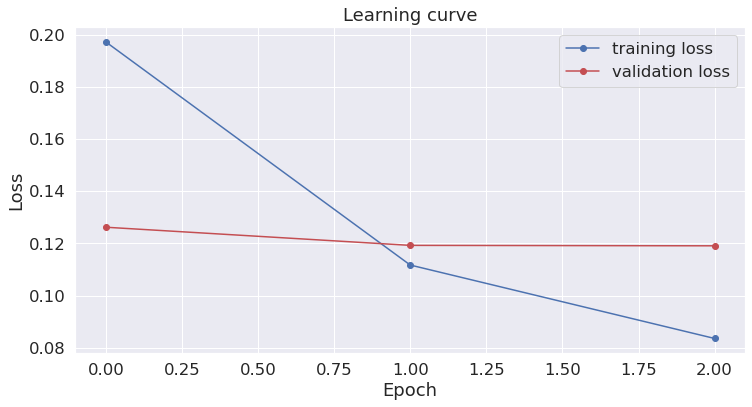

In [34]:
# Uncommend inline and show to show within the jupyter only.
import matplotlib.pyplot as plt
#%matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(loss_values, 'b-o', label="training loss")
plt.plot(validation_loss_values, 'r-o', label="validation loss")

# Label the plot.
plt.title("Learning curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

#plt.show()
#plt.savefig("training.png")

The figure above should show similart to the following:

![](training-pt.png)

In [35]:
# TEST
predictions , true_labels = [], []
for batch in tqdm(test_dataloader):
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_labels = batch

    with torch.no_grad():
        outputs = model(b_input_ids, token_type_ids=None,
                        attention_mask=b_input_mask, labels=b_labels)

    logits = outputs[1].detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    predictions.extend([list(p) for p in np.argmax(logits, axis=2)])
    true_labels.extend(label_ids)

results_predicted = [[code2label[p_i] for (p_i, l_i) in zip(p, l) if code2label[l_i] != "PAD"] 
                                      for p, l in zip(predictions, true_labels)]
results_true = [[code2label[l_i] for l_i in l if code2label[l_i] != "PAD"] 
                                 for l in true_labels]

100%|██████████| 152/152 [00:29<00:00,  5.11it/s]


In [36]:
print(f"F1 score: {f1_score(results_true, results_predicted)}")
print(f"Accuracy score: {accuracy_score(results_true, results_predicted)}")
print(classification_report(results_true, results_predicted))

F1 score: 0.8255197474236016
Accuracy score: 0.9611487886978295
              precision    recall  f1-score   support

         art       0.12      0.06      0.08        80
         eve       0.26      0.27      0.27        33
         geo       0.84      0.90      0.87      5956
         gpe       0.94      0.95      0.94      1841
         nat       0.43      0.29      0.34        21
         org       0.76      0.70      0.73      3762
         per       0.78      0.81      0.80      2749
         tim       0.85      0.84      0.84      2252

   micro avg       0.82      0.83      0.83     16694
   macro avg       0.62      0.60      0.61     16694
weighted avg       0.82      0.83      0.82     16694



The expected output of the above should be similar as follows:

```
F1 score: 0.8276047261009667
Accuracy score: 0.9615467524499643


           precision    recall  f1-score   support

      org       0.76      0.70      0.73      3762
      gpe       0.94      0.95      0.95      1841
      per       0.79      0.80      0.79      2749
      geo       0.84      0.90      0.87      5956
      tim       0.87      0.83      0.85      2252
      nat       0.31      0.38      0.34        21
      art       0.15      0.09      0.11        80
      eve       0.33      0.30      0.32        33

micro avg       0.82      0.83      0.83     16694
macro avg       0.82      0.83      0.83     16694
```

After that we can observe also the results of the following example, fed to the algorithm:

In [37]:
test_sentence = """
Dr. Marko Robnik-Šikonja is lecturing a course on NLP at the University of Ljubljana in Slovenia. 
Dr. Žitnik is having labs every Tuesday, Wednesday and Thursday. His lectures are aired at the Televizija Slovenija national TV station. 
"""

In [42]:
tokenized_sentence = tokenizer.encode(test_sentence)

if torch.cuda.is_available():
    input_ids = torch.tensor([tokenized_sentence]).to('cuda')
else:
    input_ids = torch.tensor([tokenized_sentence])


In [43]:
with torch.no_grad():
    output = model(input_ids)
label_indices = np.argmax(output[0].to('cpu').numpy(), axis=2)

In [44]:
# Join BPE split tokens
tokens = tokenizer.convert_ids_to_tokens(input_ids.to('cpu').numpy()[0])
new_tokens, new_labels = [], []
for token, label_idx in zip(tokens, label_indices[0]):
    if token.startswith("##"):
        new_tokens[-1] = new_tokens[-1] + token[2:]
    else:
        new_labels.append(code2label[label_idx])
        new_tokens.append(token)


In [45]:
for token, label in zip(new_tokens, new_labels):
    print("{}\t{}".format(label, token))


O	[CLS]
B-per	Dr
B-per	.
B-per	Marko
I-per	Robnik
I-per	-
I-per	Šikonja
O	is
O	lecturing
O	a
O	course
O	on
B-org	NLP
O	at
O	the
B-org	University
I-org	of
B-geo	Ljubljana
O	in
B-geo	Slovenia
O	.
B-per	Dr
B-per	.
I-per	Žitnik
O	is
O	having
O	labs
O	every
B-tim	Tuesday
O	,
B-tim	Wednesday
I-tim	and
I-tim	Thursday
O	.
O	His
O	lectures
O	are
O	aired
O	at
O	the
B-org	Televizija
I-org	Slovenija
O	national
O	TV
O	station
O	.
O	[SEP]


The expected output should recognize entities (by the algorithm):

* (PER) Dr. Marko Robnik-Šikonja
* (ORG) NLP
* (ORG) University of Ljubljana
* (GEO) Slovenia
* (PER) Dr. Žitnik
* (TIM) Tuesday
* (TIM) Wednesday and Thursday
* (ORG) Televizija Slovenija

## Coreference resolution

Coreference resolution can be approached in ways to exploit mention pairs for classification. We have already seen the [huggingface' example](https://huggingface.co/coref/) which is [open-sourced](https://github.com/huggingface/neuralcoref). Their model architecture looks as follows and training is described in [their medium post](https://medium.com/huggingface/how-to-train-a-neural-coreference-model-neuralcoref-2-7bb30c1abdfe):

<img src="huggingface-coref.png" width="60%" />

Another simple approach would be a combination of BERT embeddings of mention pairs and additional features combined using dense layers:

<img src="bert-pair-coref.png" width="60%" />

The model is described along with two additional baselines in the report [BERT for Coreference Resolution by Arthi Sureb](bert-pair-coref.pdf) (Stanford's NLP/AI class). 

## Aspect-based sentiment analysis

This task is quite novel and therefore I propose to try some architectures of your own. 

Still you are free to transform the task to sequence classification. For example, you can represent a sequence of a persion based on sequence of mentions with additional word neighbourhoods.

There exist some BERT-based approaches ([an example](ABSA.pdf)) that deal with aspect-based sentiment analysis. Still, their task is a bit different and is based on SemEval 2015 and SemEval 2016 tasks. Those task are investigating different sentiment aspects for a given entity type in a review text. 

## References

* [Transformers NER examples](https://github.com/huggingface/transformers/tree/master/examples/ner)
* [NER example in Tensorflow](https://androidkt.com/name-entity-recognition-with-bert-in-tensorflow/)
* [DeepPavlov models](http://docs.deeppavlov.ai/en/master/features/models/ner.html)

## Other interesting examples

* [Data Science workshop by Andrej Miščič and Luka Vranješ](https://github.com/andrejmiscic/NLP-workshop)